# Using the Consumer Reports “car90” 1990 Dataset to Classify Purchases as Good, Bad, or Mediocre. 

 Looking at consumer reports car data from 1990, we want to create a classification to indicate whether a car purchase would have been a good decision for the typical American city dweller. To start answering this question, we need to know what the typical American city dweller needs were in terms of a car. This will help us pin point which groupings of vehicles (based off of several of factors) would best fit their needs. To do this we will need to make the below assumptions:


- The city dweller persona in 1990 didn't have significantly different budgeting constraints than the typical household at the time (median HHI of $29,943 - [St. Louis Fed](https://fred.stlouisfed.org/series/MEHOINUSA646N)). We need this assumption so we don't prioritize features such as horsepower over price for example. It will allow us to use reliability and price as the main features of focus for this demographic.
- The typical city dweller was not driving kids around. This assumption allows us to simplify further by not making a recommendation based off vehicle size, which is mostly dependent on personal preferences if not work or family needs.
- They didn't have a special loyalty to particular brands or car maker countries. This assumption allows us to focus more on numerical variables such as price (or variables less dependent on varying consumer preferences).


### Methodology

The goal of this analysis is to classify 111 vehicles as either a good, mediocre, or bad purchase for a 1990 American city dweller. Since this dataset contains lots of numerical variables, clustering would be a good candidate for creating groupings for the vehicles. We will need to carefully analyze the results to see if the groupings are logical and match our expectations. Once each vehicle is assigned to a cluster, we can note the overarching characteristics of each cluster and assign them a good, mediocre, or bad score based on how they align with our assumptions about an American city dweller in 1990. If the resulting clusters do not match our expectations or differentiate vehicles in a logical way, we will need to approach the problem differently. Below notes some of the expectations for the analysis:

- There will be a cluster that comprises of smaller non-luxury vehicles
- The clustering will pick up price as a major source of differentiation
- There will be a cluster with higher performance and luxury vehicles

### Analysis

In [9]:
library(cluster)
library(purrr)
library(dplyr)
library(corrplot)
library(ggplot2)

In [10]:
# read in data set


  raw_data <- read.csv("car90.csv", header = TRUE)
  ds <- raw_data %>%
    rename("car" = "X")
  ds <- data.frame(ds)
  head(ds)

car,Country,Disp,Disp2,Eng.Rev,Front.Hd,Frt.Leg.Room,Frt.Shld,Gear.Ratio,Gear2,...,Steering,Tank,Tires,Trans1,Trans2,Turning,Type,Weight,Wheel.base,Width
Acura Integra,Japan,112,1.8,2935,3.5,41.5,53.0,3.26,3.21,...,power,13.2,195/60,man.5,auto.4,37,Small,2700,102,67
Acura Legend,Japan,163,2.7,2505,2.0,41.5,55.5,2.95,3.02,...,power,18.0,205/60,man.5,auto.4,42,Medium,3265,109,69
Audi 100,Germany,141,2.3,2775,2.5,41.5,56.5,3.27,3.25,...,power,21.1,205/60,man.5,auto.3,39,Medium,2935,106,71
Audi 80,Germany,121,2.0,2835,4.0,42.0,52.5,3.25,3.25,...,power,15.9,175/70,man.5,auto.3,35,Compact,2670,100,67
BMW 325i,Germany,152,2.5,2625,2.0,42.0,52.0,3.02,2.99,...,power,16.4,195/65,man.5,auto.4,35,Compact,2895,101,65
BMW 535i,Germany,209,3.5,2285,3.0,42.0,54.5,2.80,2.85,...,power,21.1,225/60,man.5,auto.4,39,Medium,3640,109,69


##### Exploratory Data Analysis

Below we see that there are a number of variables with missing values. Some only have a handful, but others such as 'Mileage' and 'Sratio.m' have a large portion missing.

In [11]:
# inspect data set
summary(ds)

            car           Country        Disp           Disp2      
 Acura Integra:  1   USA      :39   Min.   : 61.0   Min.   :1.000  
 Acura Legend :  1   Japan    :31   1st Qu.:111.2   1st Qu.:1.800  
 Audi 100     :  1   Germany  :10   Median :141.0   Median :2.300  
 Audi 80      :  1   Japan/USA: 9   Mean   :156.0   Mean   :2.571  
 BMW 325i     :  1   Korea    : 5   3rd Qu.:181.0   3rd Qu.:3.000  
 BMW 535i     :  1   (Other)  :11   Max.   :350.0   Max.   :5.700  
 (Other)      :105   NA's     : 6   NA's   :3       NA's   :3      
    Eng.Rev        Front.Hd      Frt.Leg.Room      Frt.Shld      Gear.Ratio   
 Min.   :1335   Min.   :1.500   Min.   :39.00   Min.   :50.5   Min.   :1.670  
 1st Qu.:2330   1st Qu.:3.000   1st Qu.:41.00   1st Qu.:53.0   1st Qu.:2.730  
 Median :2575   Median :3.500   Median :41.50   Median :55.0   Median :2.950  
 Mean   :2575   Mean   :3.414   Mean   :41.41   Mean   :55.2   Mean   :2.941  
 3rd Qu.:2825   3rd Qu.:4.000   3rd Qu.:42.00   3rd Qu.:57.0 

We can get a general understanding of how these variables relate to each other and make sure it is in line with what we would expect to see. For example, 'Width' and 'Weight' have a strong positive correlation.

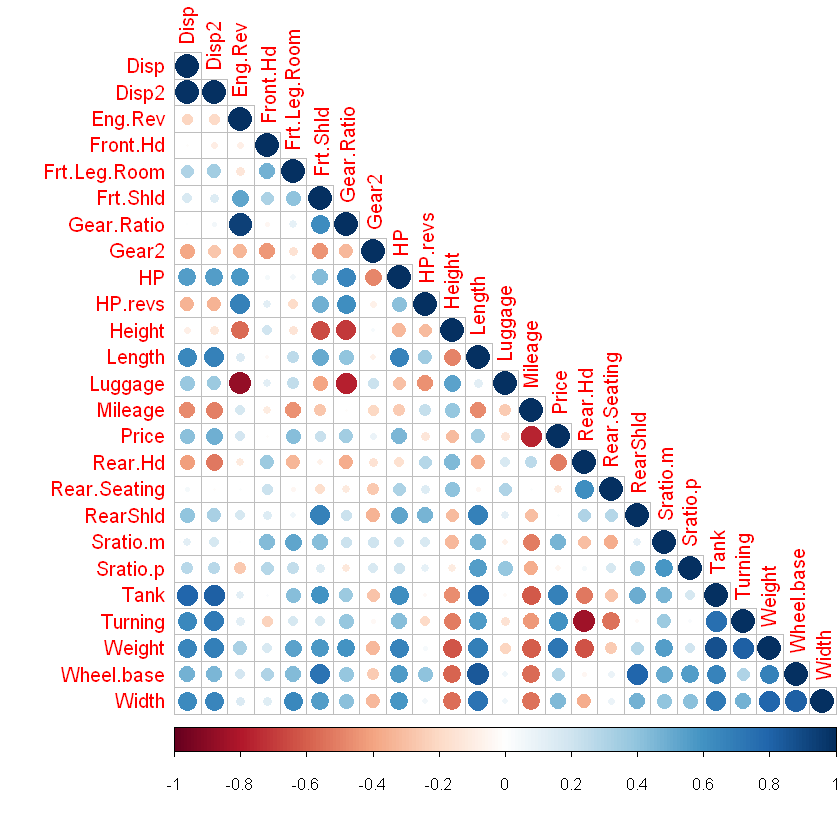

In [12]:
  corr <- sapply(ds, class) # Identify numeric variables
  corr_viz <- ds %>% select(which(corr=="integer" | corr == "numeric")) # Select only numeric variables
  
  corrplot(cor(na.omit(corr_viz)),method = "circle", type = "lower") # remove N/A's from plot
  

##### Data prep 
We will now set up the data for clustering. We will leave out numeric variables with 10 or more missing values. The rest of the numeric variables will be clustered with missing values using an average of the whole column.

In [17]:
 

remove_numeric_cols <- c( "Mileage" , "Eng.Rev", "Gear.Ratio", "Sratio.m")
ds_reduced <- select( ds ,-remove_numeric_cols ) # remove high n/a count variables


  var_types <- sapply(ds_reduced, class) # Identify numeric variables
  clust <- ds_reduced %>% select(which(var_types=="integer" | var_types == "numeric")) # Only clustering numeric variables

 # Add a flag to find cars that used imputation after clustering
  impute_ds <- data.frame(ds$car)
  for(i in 1:nrow(clust)){
    impute_ds$imputation_flg[i] <- ifelse(rowSums(is.na(clust[i,])) > 0 , 1 , 0  )
    
  }
  
  # mean imputation on missing numeric variables needed to cluster cars
  
  for(i in 1:ncol(clust)){
    clust[is.na(clust[,i]), i] <- mean(clust[,i], na.rm = TRUE)
  }


We see below that 4 clusters appear to be a good choice, as that is the point where adding clusters doesn't add much additional benefit in minimizing the total WSS.

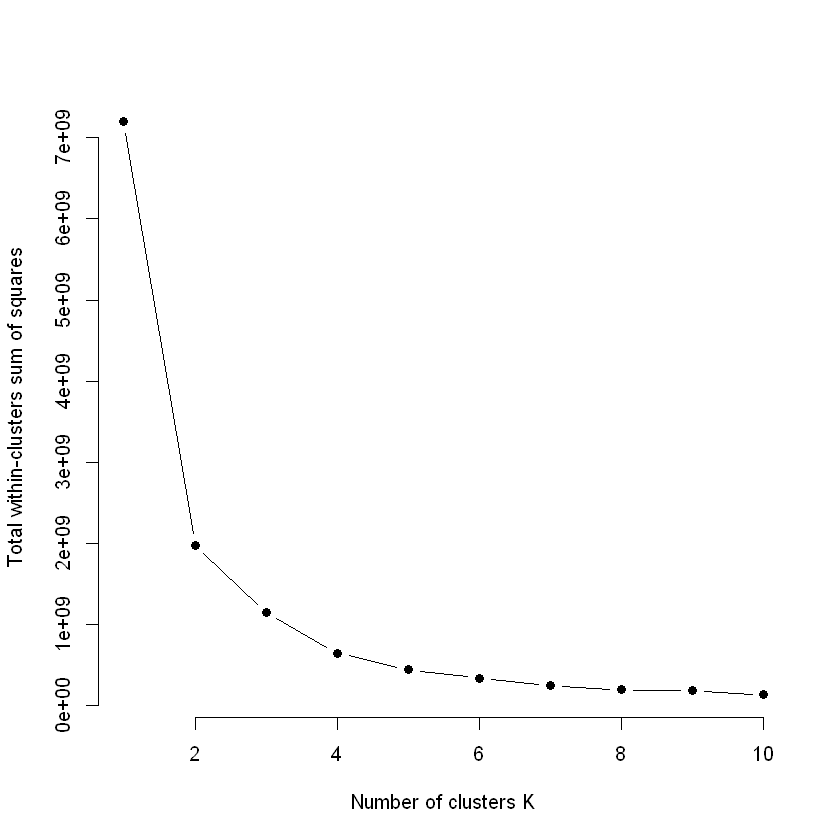

In [18]:
# function to compute total within-cluster sum of square 
  wss <- function(k) {
    kmeans(clust, k, nstart = 10 )$tot.withinss
    }

# Compute and plot wss for k = 1 to k = 10
  k.values <- 1:10

# extract wss for 1-10 clusters
wss_values <- map_dbl(k.values, wss)

plot(k.values, wss_values,
     type="b", pch = 19, frame = FALSE, 
     xlab="Number of clusters K",
     ylab="Total within-clusters sum of squares")


# elbow at 4 clusters

##### Cluster the data and join results back with original dataset

In [19]:
 set.seed(1234)
cluster_results <- kmeans(clust, 4 )


results <- data.frame(cluster_results$cluster)

ds$row <- row.names(ds) # Add row number to main dataset
results$row <- row.names(results) # Add row number to cluster results
impute_ds$row <- row.names(clust) # Add row number to cluster 
results$cluster <- as.factor( results$cluster_results.cluster )

combined_data <- left_join(ds, results, by = c("row"="row")) # Join cluster results to main data set
combined_data <- left_join(combined_data, impute_ds, by = c("row"="row"))

##### Visually inspect results
We see that price and weight do explain a lot of the clusters. To explore further and categorize as a good, mediocre, or bad purchase we will use a spreadsheet.

Warning message:
"Removed 6 rows containing missing values (geom_point)."

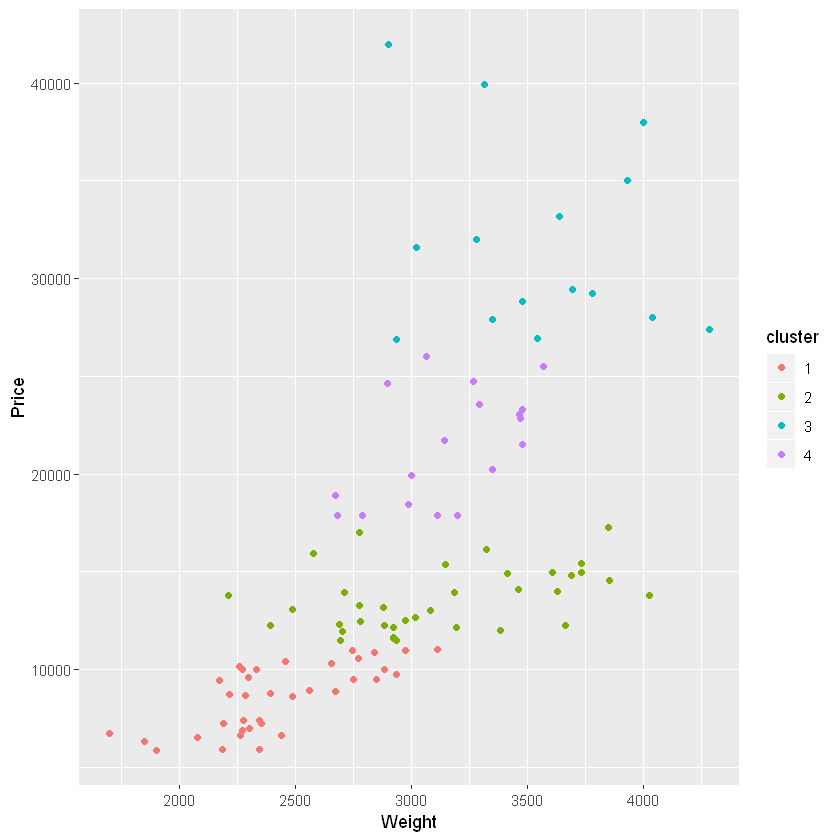

In [20]:
# Visually inspect 4 clusters by significant variables


ggplot(subset(combined_data, !is.na(combined_data$cluster_results.cluster)) 
       , aes(x=Weight, y=Price, color=cluster)) +
  geom_point() 

write.csv(combined_data, 'cluster_cars.csv') # export to CSV for manual inspection

### Results

After digging into the spreadsheet, below are some of the key findings:

##### Cluster 1
This cluster consists primarily of smaller vehicles and has a high reliability score (% ratings marked as 'Much better' and better') of 36%, while also being the lowest price point. Based off our assumptions about American city dwellers in 1990, we will rank vehicles in this cluster with as a 'Good Purchase'.

##### Cluster 2
This cluster tended to pick up a fair amount of larger vehicles such as vans (not seen in cluster 1). The larger vehicle size seems to explain at least some of the increase in price from cluster 1. Since this cluster is still representing a relatively low price point when compared to clusters 3 and 4, and tends to have average reliability; we will rank vehicles in this cluster as a 'Mediocre Purchase'.

##### Cluster 3
This cluster tends to have luxury/higher performance vehicles. The cars in this group have the highest price points and poor reliability (% ratings marked as 'worse' and 'much worse' made up 33% of this group). Due to these factors and our assumptions about our personas needs, we will rank vehicles in this group as a 'bad purchase'.

##### Cluster 4
While the average price of vehicles in this cluster is lower than cluster 3 and has much better reliability, we will rank this as a 'bad purchase' due to the price point difference from cluster 1 and cluster 2.

### Additional Comments

The biggest challenge in this analysis was categorizing cars missing most of their data points. Another challenge came with certain numerical variables having too many N/As, to the point where mean imputation would have likely skewed the results too much. That is why I decided to eliminate those variables from the clustering entirely.

While the analysis produced logical groupings for the 111 vehicles, more data on the consumer would have been helpful. Due to the lack of information on the typical American city dweller, we had to make some broad brush assumptions to assign a cluster one of three labels. It would be even more interesting to rank purchases within each cluster individually, or have more than three categories available to allow for more scoring within each cluster.